In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

## 1. About Dataset

$~$

#### Context
This is the dataset used in the second chapter of Aurélien Géron's recent book 'Hands-On Machine Learning with Scikit-Learn and TensorFlow'. It serves as an excellent introduction to implementing machine learning algorithms because it requires rudimentary data cleaning, has an easily understandable list of variables and sits at an optimal size between being to toyish and too cumbersome.

The data contains information from the 1990 California census. So although it may not help you with predicting current housing prices like the Zillow Zestimate dataset, it does provide an accessible introductory dataset for teaching people about the basics of machine learning

$~$

#### Content
The data describes houses in various California districts, along with summary statistics based on 1990 census data. Note that the data is not pre-cleaned, so preprocessing steps are required. The columns are as follows:

1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

$~$

#### Goal 
The goal of this project is to create a Linear Regression model to predict median_house_value (the target variable). Linear Regression will be implemented using:

- The normal equation

- Batch Gradient Descent (BGD)

- Stochastic Gradient Descent (SGD)

- Mini-Batch Gradient Descent (MBGD)

Additionally, models with and without regularization will be explored, as well as polynomial regression models.

$~$


## 2. Data Preparation

### 2.1. Loading dataset

In [2]:
dataset = pd.read_csv('housing.csv')
dataset = dataset.drop(columns=["ocean_proximity"])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


There are 207 examples with missing value. This can be dealt with in different ways, but because here the main focus is making a good model, examples with missing data will be removed (since it is small percentage of the data 207/20640).

In [3]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [4]:
dataset.head().T

,0,1,2,3,4
longitude,-122.2300,-122.2200,-122.2400,-122.2500,-122.2500
latitude,37.8800,37.8600,37.8500,37.8500,37.8500
housing_median_age,41.0000,21.0000,52.0000,52.0000,52.0000
total_rooms,880.0000,7099.0000,1467.0000,1274.0000,1627.0000
total_bedrooms,129.0000,1106.0000,190.0000,235.0000,280.0000
population,322.0000,2401.0000,496.0000,558.0000,565.0000
households,126.0000,1138.0000,177.0000,219.0000,259.0000
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600.0000,358500.0000,352100.0000,341300.0000,342200.0000


Now let's drop invalid data.

In [5]:
dataset = dataset.dropna()

### 2.2. Data split
Now we'll split our data into training, validation and test sets. Validation set will be used for fine tuning of the parameters and test set will be used for testing performances of the final model. We are going to use 70/15/15 split.

In [6]:
data_train, data_rest = train_test_split(dataset,test_size=0.3,random_state=42)
data_val, data_test = train_test_split(data_rest,test_size=0.5,random_state=42)

## 3. EDA
Let's find out something more about our dataset through exploratory data analysis

### 3.1. Univariate analysis
Univariate analysis examines one variable at a time to understand its distribution, characteristics, and potential impact on the model. We'll try to understand the distribution of the data, skewness, identify outliers and see the scales of our features.

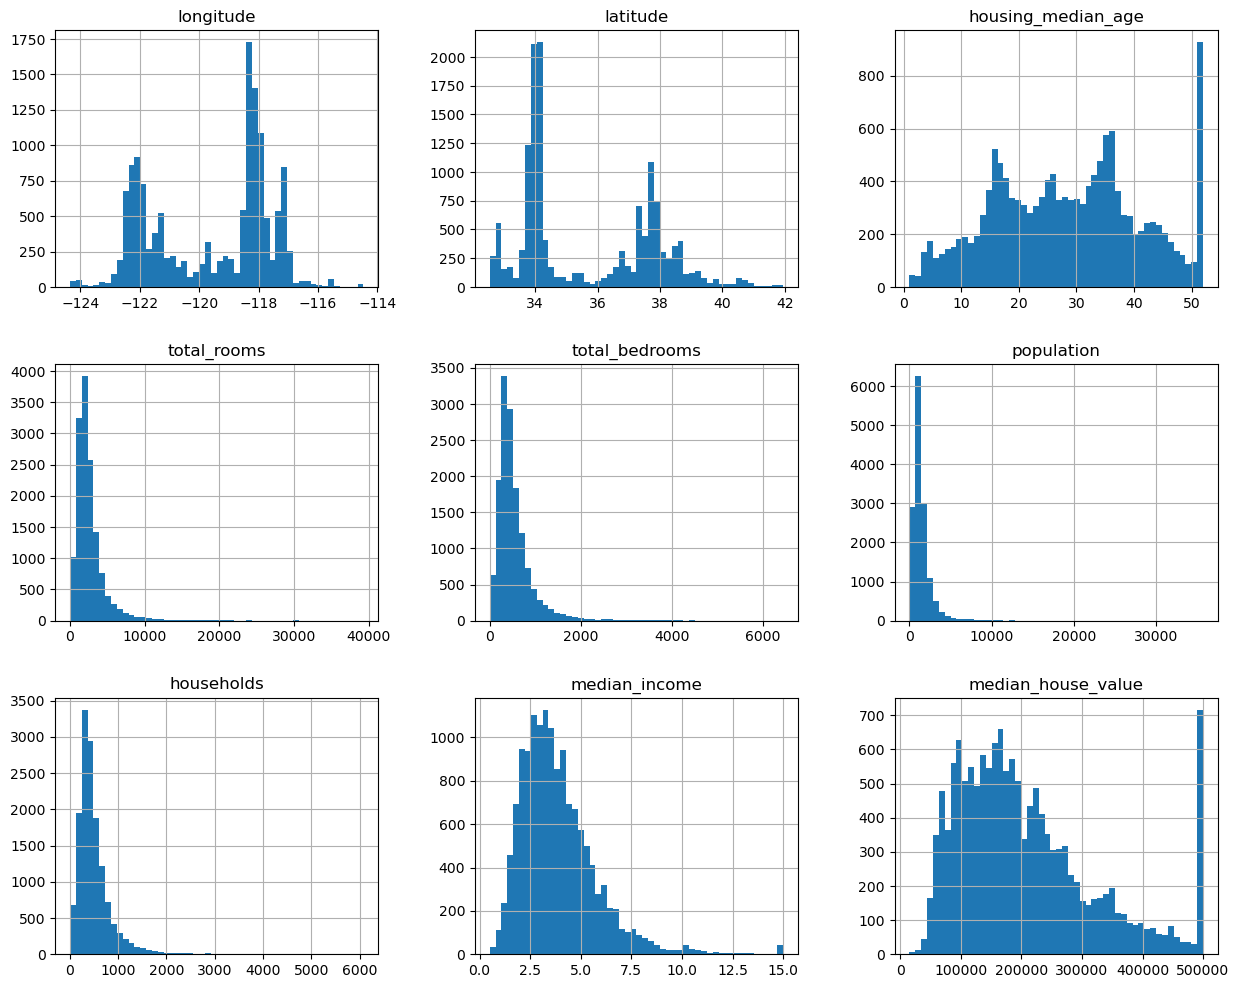

In [7]:
data_train.hist(bins = 50, figsize=(15,12))
plt.show()

First, we see odd picks at maximums for features housing_median_age and median_house_value which might be outliers. This might indicate that examples with higher value than shown maximum were capped at that maximum value.

Households, total_rooms, total_bedrooms and population are scewed to the left. Also they contain small amount of examples with high value (hard to see bins) which is indicated by the range of the values on x-axis.

median_income is also skewed, but that is to be expected because small amount of people would have a higher salary then the rest. There is also a small peak at the maximum.

We can also see identical distribution of total_rooms and total_bedrooms which suggest connection between the two.

Latitude and longitude distributions show clear clustering patterns, reflecting California’s population centers.



### 3.2. Bivariate analysis

Bivariate analysis examines the relationship between two variables to understand their association, patterns, or dependencies. The goal is to determine how one variable changes with respect to another (e.g., correlation, causation, or trends).

We will be analyzing both pearson and spearman correlation coefficients. Spearman might help us see some non-linear relations between our features.

In [8]:
corr_pearson = data_train.corr(method = 'pearson').round(2)
corr_spearman = data_train.corr(method = 'spearman').round(2)
mask = np.zeros_like(corr_pearson)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        mask[i][j] = j >= i

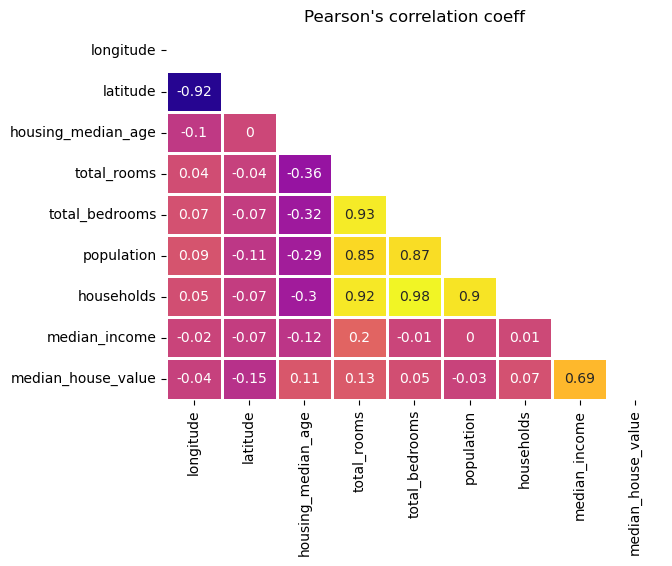

In [9]:
sns.heatmap(corr_pearson,mask=mask,vmin=-1,vmax=1,center=0, cmap='plasma',square=False,lw=2,annot=True,cbar=False)
plt.title('Pearson\'s correlation coeff')
plt.show()  

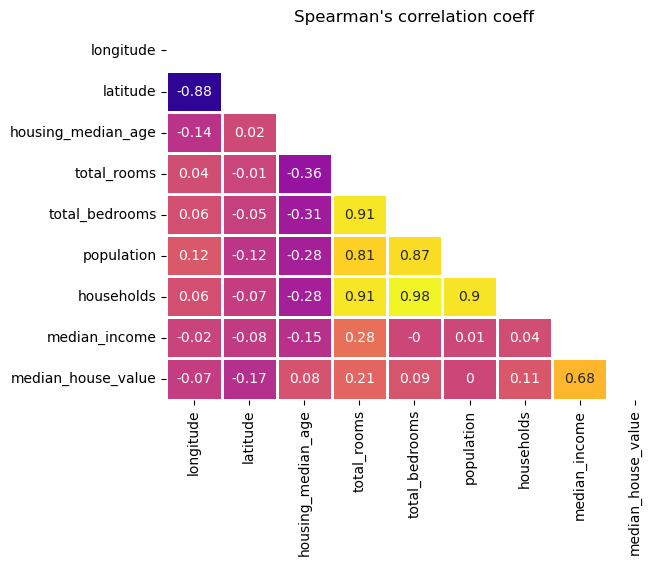

In [10]:
sns.heatmap(corr_spearman,mask=mask,vmin=-1,vmax=1,center=0, cmap='plasma',square=False,lw=2,annot=True,cbar=False)
plt.title('Spearman\'s correlation coeff')
plt.show()  

We observe that total_bedrooms, total_rooms, households, and population are all highly correlated with one another (both in Pearson's and Spearman's correlation matrices). This multicollinearity could potentially harm model performance and interpretability if not addressed, for example, by feature selection or dimensionality reduction.

Additionally, longitude and latitude show a very strong negative correlation, which reflects the geographical structure of the dataset (as locations more west are also more south in California).

It's particularly important to highlight that median_income shows the strongest correlation with the target variable median_house_value (Pearson's r = 0.69, Spearman's rho = 0.68). Other features show either mild or weak correlations with the target.

The population feature has very low correlation with the target and could potentially be dropped or combined with other variables (e.g., population per household or population per room might provide more insight).

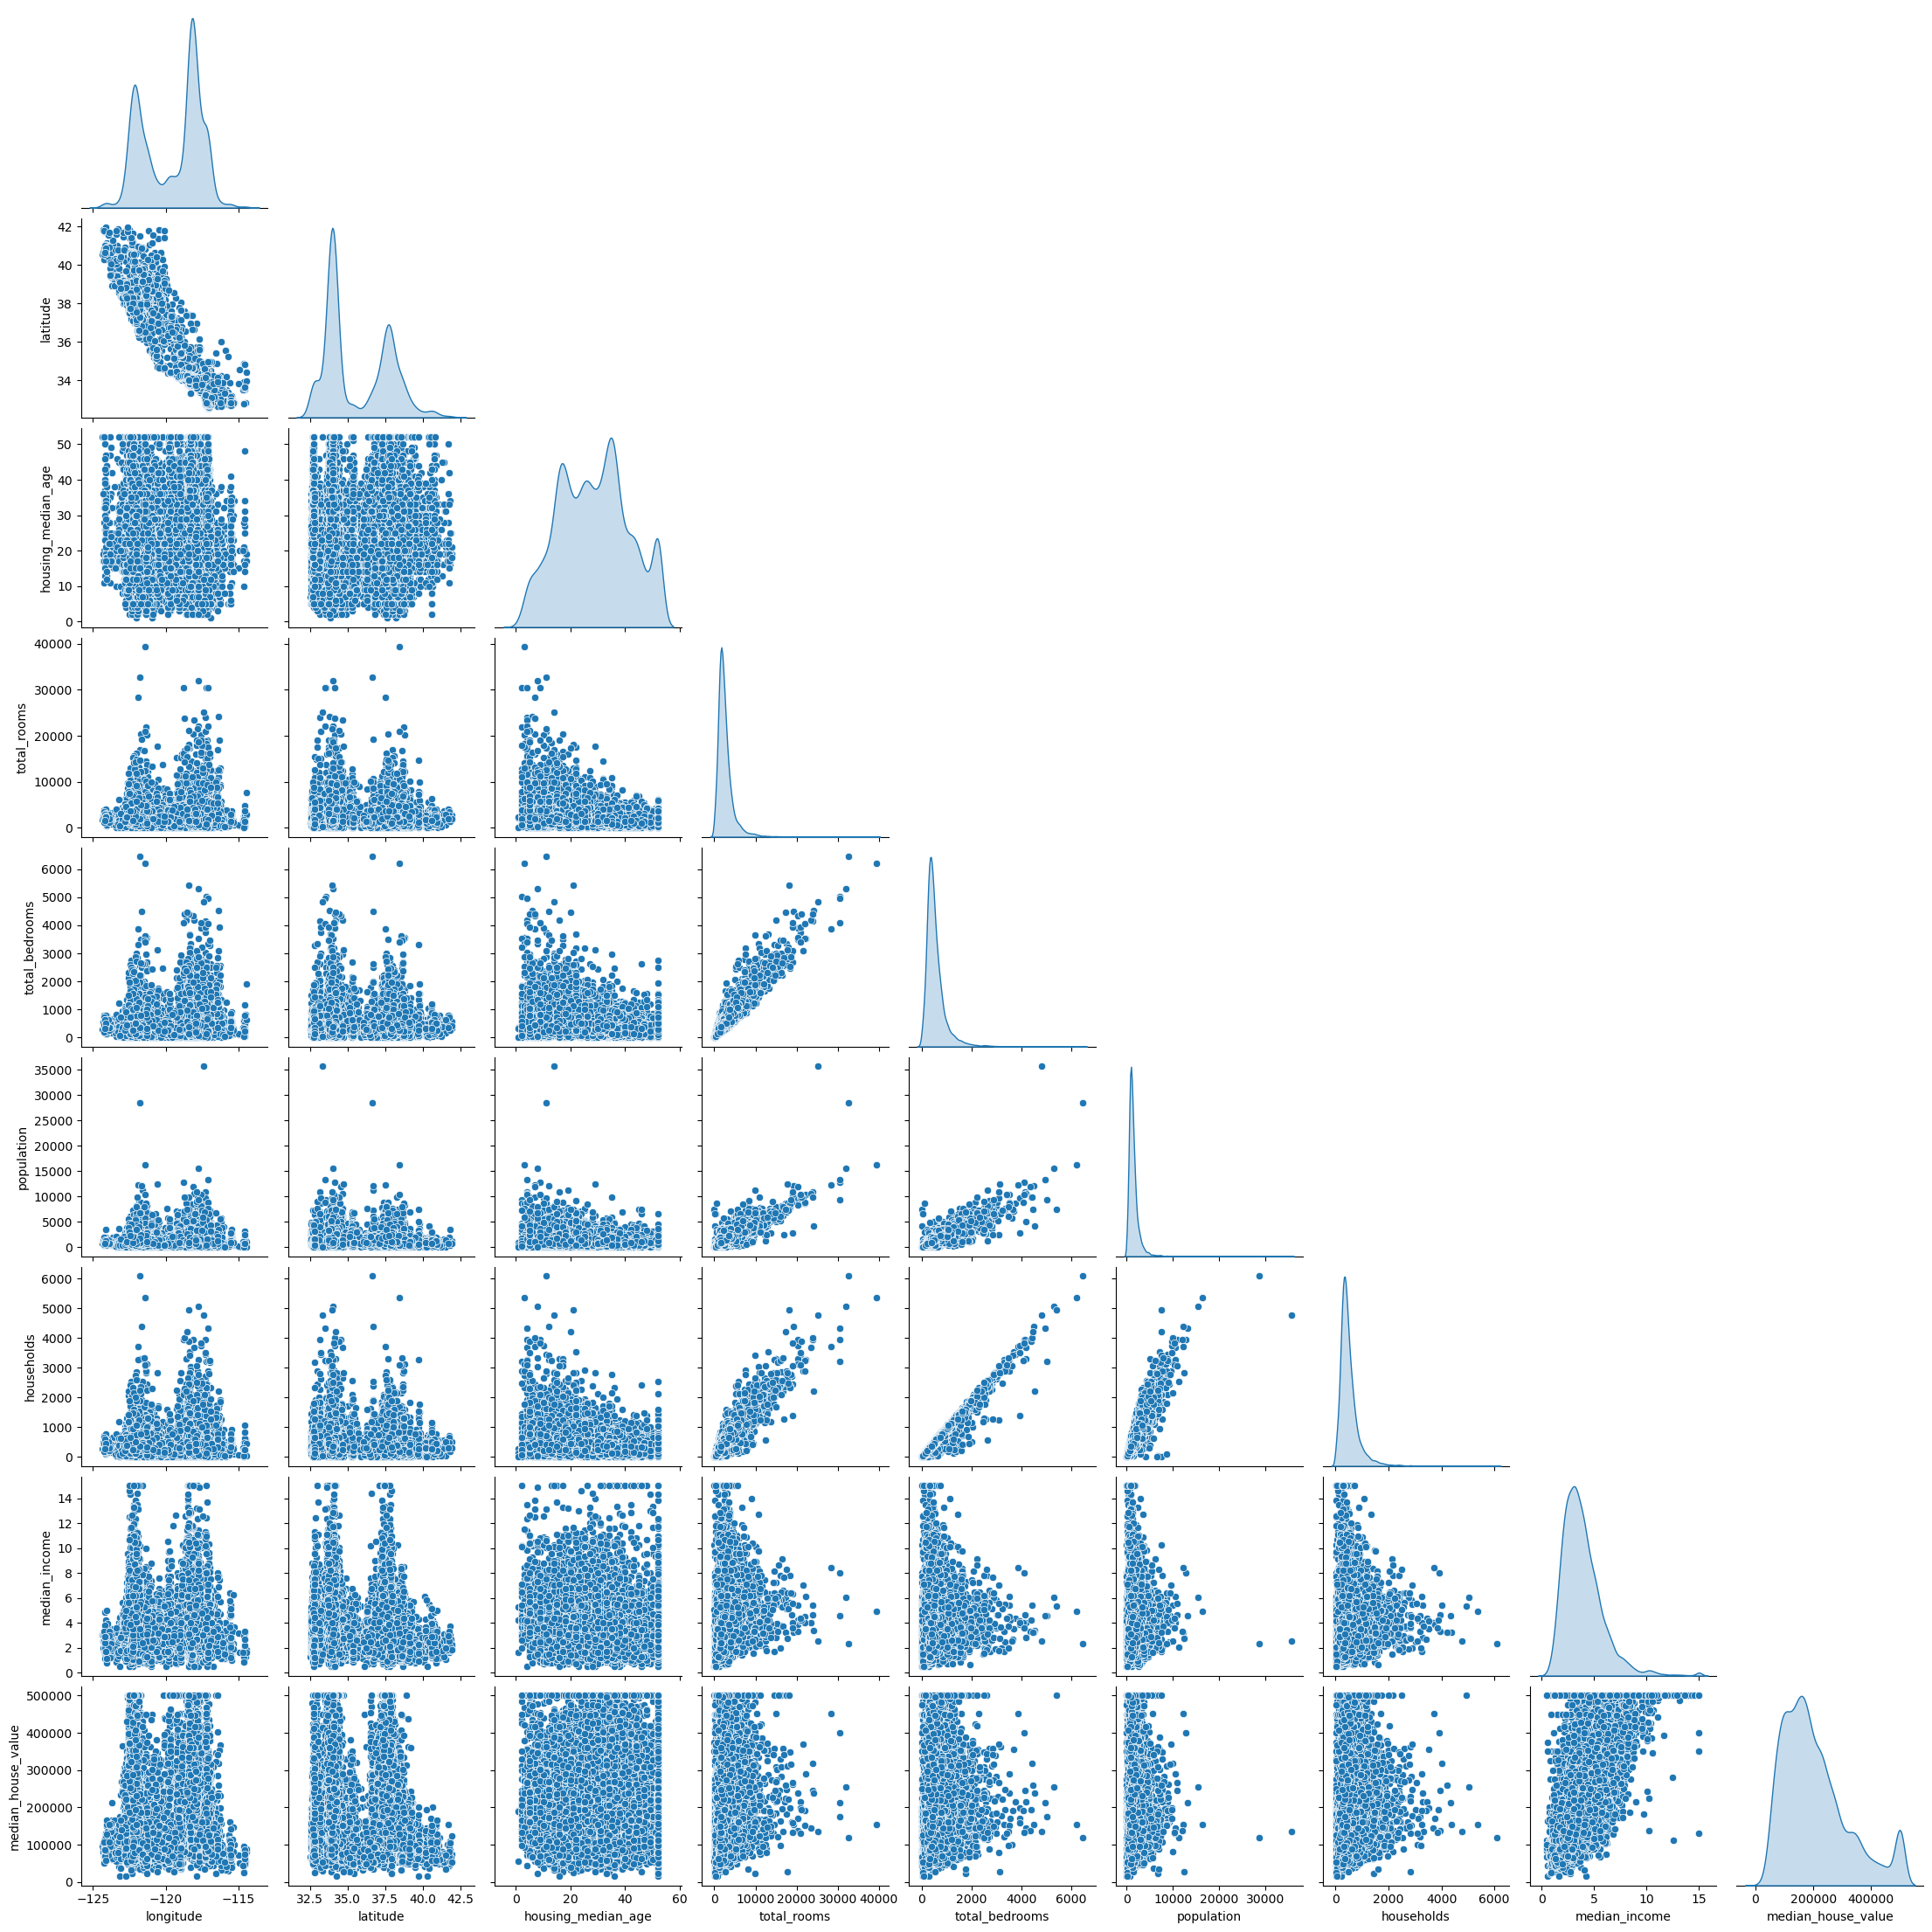

In [11]:
sns.pairplot(data_train, diag_kind="kde", corner=True)
plt.show()

As expected, total_rooms, total_bedrooms, population, and households are all highly linearly related to one another.

The strongest visible trend is between median_income and median_house_value, where we can see a clear positive correlation. However, there is also a visible horizontal line near the house value limit, confirming that the target variable was capped at around 500000. This cap can lead to issues in prediction and should be considered during modeling

Most other relationships with the target are either noisy or show curved boundaries, which might not be captured well by simple linear models. This suggests that more complex models or feature transformations could improve performance.

## 4. Data processing

### 4.1 Outliers
Firstly we noticed outliers in feature housing_median_age and median_house_value so those examples will be romoved.

In [12]:
max_age = data_train['housing_median_age'].max()
max_val = data_train['median_house_value'].max()

data_train_new = data_train[(data_train['housing_median_age'] != max_age) & (data_train['median_house_value'] != max_val)]
data_test_new = data_test[(data_test['housing_median_age'] != max_age) & (data_test['median_house_value'] != max_val)]
data_val_new = data_val[(data_val['housing_median_age'] != max_age) & (data_val['median_house_value'] != max_val)]

### 4.2 Feature Engineering
We saw that longitude and latitude have high correlation, so we can combine them into 1 feature that is gonna be longitude+latitude.

Also we saw that total_bedrooms, total_rooms, households have high correlation. We already removed population. We also can remove total_bedrooms because it has lowest correlation to the target of the three left, and other 2 combine into number of rooms per houshold, i.e. total_rooms / households.

In [13]:
def transform_dataset(df):
    df = df.copy()
    df['coordinate'] = df['longitude'] + df['latitude']
    df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
    df['population_per_hh'] = df['population'] / df['households']
    df = df.drop(columns=['longitude', 'latitude', 'total_rooms', 'total_bedrooms', 'households', 'population'])
    return df

data_train_new = transform_dataset(data_train_new)
data_test_new = transform_dataset(data_test_new)
data_val_new = transform_dataset(data_val_new)

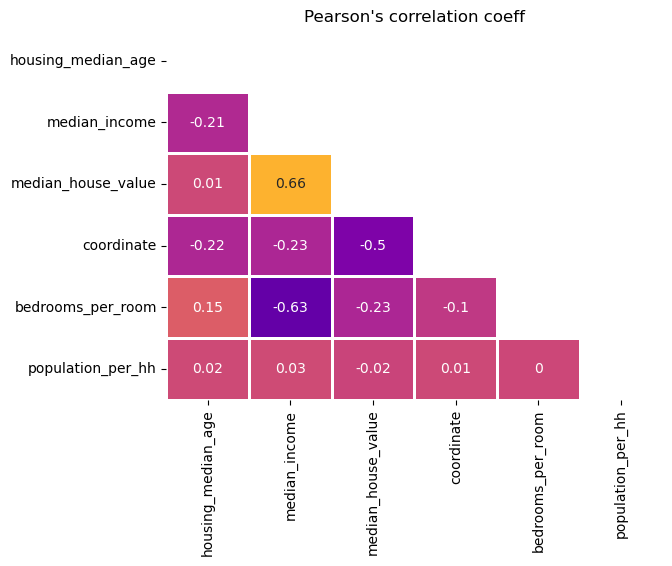

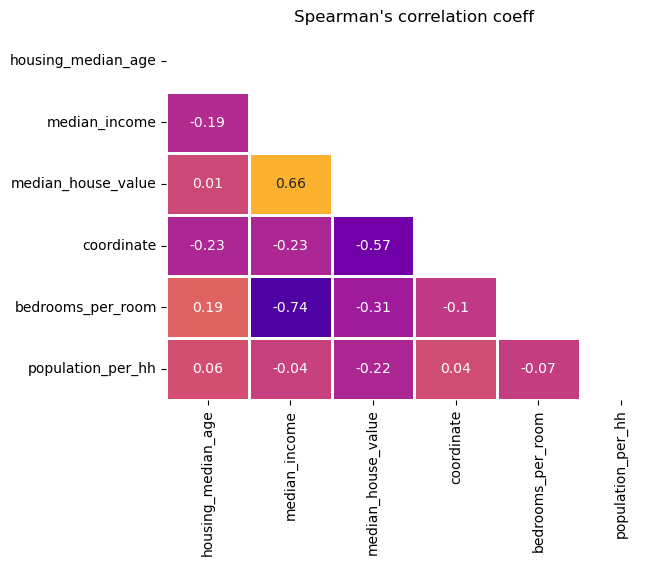

In [14]:
corr_pearson = data_train_new.corr(method = 'pearson').round(2)
corr_spearman = data_train_new.corr(method = 'spearman').round(2)
mask = np.zeros_like(corr_pearson)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        mask[i][j] = j >= i

plt.figure()
sns.heatmap(corr_pearson,mask=mask,vmin=-1,vmax=1,center=0, cmap='plasma',square=False,lw=2,annot=True,cbar=False)
plt.title('Pearson\'s correlation coeff')
plt.show()  

plt.figure()
sns.heatmap(corr_spearman,mask=mask,vmin=-1,vmax=1,center=0, cmap='plasma',square=False,lw=2,annot=True,cbar=False)
plt.title('Spearman\'s correlation coeff')
plt.show()  

Now we will split our data and target and we will be making our model

In [56]:
Y_train = data_train_new['median_house_value'].to_numpy()
X_train = data_train_new.drop(columns=['median_house_value']).to_numpy()

Y_test = data_test_new['median_house_value'].to_numpy()
X_test = data_test_new.drop(columns=['median_house_value']).to_numpy()

Y_val = data_val_new['median_house_value'].to_numpy()
X_val = data_val_new.drop(columns=['median_house_value']).to_numpy()

### 4.3. Normalization


In [57]:
# def scale_data(data, mean=None, std=None):
#     if mean is None and std is None:
#         mean = data.mean(axis=0)
#         std = data.std(axis=0)
#     return (data - mean) / std, mean, std

# X_train_scaled, mean_X, std_X = scale_data(X_train)
# X_test_scaled, _, _ = scale_data(X_test, mean_X, std_X)
# X_val_scaled, _, _ = scale_data(X_val, mean_X, std_X)

# Y_train_scaled, Y_mean, Y_std = scale_data(Y_train)
# Y_test_scaled, _, _ = scale_data(Y_test, Y_mean, Y_std)
# Y_val_scaled, _, _ = scale_data(Y_val, Y_mean, Y_std)

# X_train_scaled, Y_train_scaled = shuffle(X_train_scaled, Y_train_scaled, random_state=42)


In [58]:
data_train_scaled = (data_train_new - data_train_new.mean(axis=0)) / data_train_new.std(axis=0)
data_test_scaled = (data_test_new - data_train_new.mean(axis=0)) / data_train_new.std(axis=0)
data_val_scaled = (data_val_new - data_train_new.mean(axis=0)) / data_train_new.std(axis=0)
X_train = data_train_new.drop(columns=['median_house_value']).to_numpy()
X_test = data_test_new.drop(columns=['median_house_value']).to_numpy()
X_val = data_val_new.drop(columns=['median_house_value']).to_numpy()

Y_train = data_train_new['median_house_value'].to_numpy()
Y_test = data_test_new['median_house_value'].to_numpy()
Y_val = data_val_new['median_house_value'].to_numpy()

X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

Y_mean = Y_train.mean()
Y_std = Y_train.std()
Y_train_scaled = (Y_train - Y_mean) / Y_std
Y_test_scaled = (Y_test - Y_mean) / Y_std
Y_val_scaled = (Y_val - Y_mean) / Y_std

## 5. Linear Regression Model

In [18]:
class LinearRegression():
    
    def __init__(self, theta = None,lr=0.001, max_epochs=1000, eps = 1e-15):
        self.theta = theta
        self.lr = lr
        self.max_epochs = max_epochs
        self.eps = eps
        
    def fit(self, X, Y):
        pass
    
    def predict(self, X):
        return (X @ self.theta).flatten()

### 5.1. Normal equation Linear Regression Model

In [88]:
class LR1(LinearRegression):
    def fit(self, X, Y):
        self.theta = np.linalg.pinv(X.T @ X) @ X.T @ Y
        #self.theta = np.linalg.solve(X.T @ X, X.T @ Y)

In [89]:
X_train_augmented = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
X_test_augmented = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
X_val_augmented = np.concatenate((X_val, np.ones((X_val.shape[0], 1))), axis=1)

lr1 = LR1()
lr1.fit(X_train_augmented, Y_train_scaled)

In [90]:
Y_pred_val = lr1.predict(X_val_augmented)* Y_std + Y_mean

In [91]:
print(f'MSE for linear model with normal equation is :{sum((Y_pred_val - Y_val)**2) / len(Y_val):.2f}')

MSE for linear model with normal equation is :3885912611.04


Let's try Polynomial Regression models and compare their MSE on validation and training sets. We will be using 1-7 degrees Polynomial Regression.

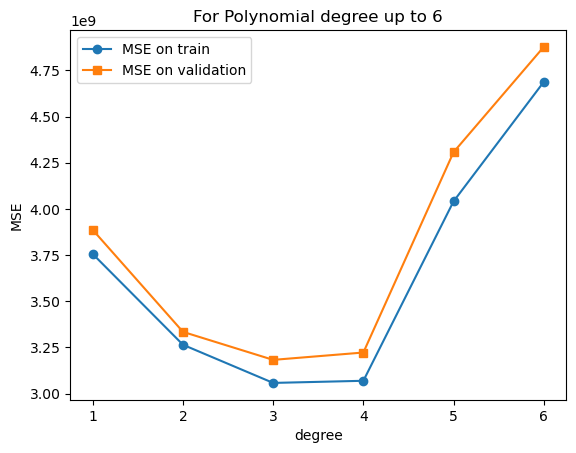

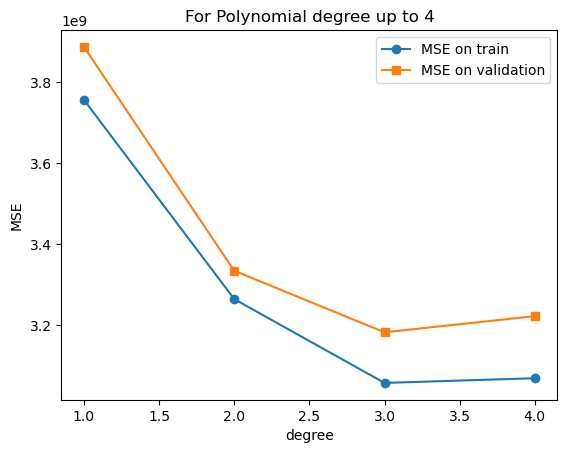

In [92]:
n = 6
MSE_train = []
MSE_val = []

for i in range(1, n+1):
    poly = PolynomialFeatures(degree=i, include_bias=True)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)
    lr = LR1()
    lr.fit(X_train_poly, Y_train_scaled)
    Y_pred_train = lr.predict(X_train_poly)* Y_std + Y_mean
    Y_pred_val = lr.predict(X_val_poly)* Y_std + Y_mean
    MSE_train.append(mean_squared_error(Y_pred_train, Y_train))
    MSE_val.append(mean_squared_error(Y_pred_val, Y_val))
    

plt.figure()
plt.plot(np.arange(1,n+1), MSE_train, marker='o')
plt.plot(np.arange(1,n+1), MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.xlabel('degree')
plt.ylabel('MSE')
plt.title(f'For Polynomial degree up to {n}')
plt.show()


plt.figure()
plt.plot(np.arange(1,4+1), MSE_train[:4], marker='o')
plt.plot(np.arange(1,4+1), MSE_val[:4], marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.xlabel('degree')
plt.ylabel('MSE')
plt.title('For Polynomial degree up to 4')
plt.show()



In [93]:
best_fit_degree_normal = np.argmin(MSE_val)+1
print(f'Best fitting model is degree {best_fit_degree_normal} of Polynomial Regression and MSE is {min(MSE_val):.2f}')

Best fitting model is degree 3 of Polynomial Regression and MSE is 3183025184.84


In [94]:
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
best_lr1_poly = LR1()
best_lr1_poly.fit(X_train_poly, Y_train_scaled)

### 5.2. Newton's Method Linear Regression Model

In [95]:
class LR2(LinearRegression):
    def fit(self, X, Y):
        if self.theta is None or self.theta.shape[0] != X.shape[1]:
            self.theta = np.zeros((X.shape[1], 1))

        for i in range(self.max_epochs):
            theta_prev = self.theta.copy()
            dJ = - X.T @ (Y - X @ self.theta) 
            H = X.T @ X + 1e-5 * np.eye(X.shape[1])              
            self.theta -= np.linalg.pinv(H) @ dJ
            if np.linalg.norm(self.theta - theta_prev) < self.eps:
                break


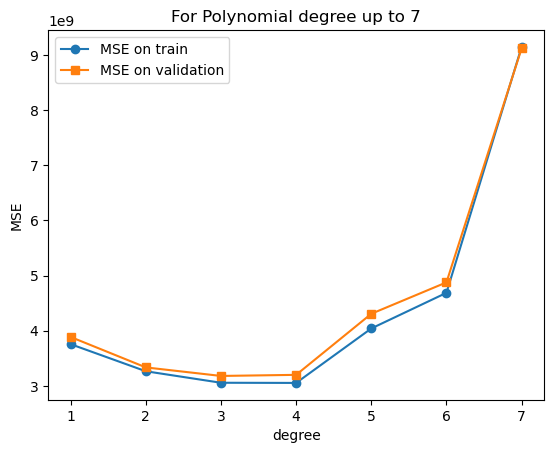

In [240]:
n = 7
MSE_train = []
MSE_val = []

for i in range(1, n+1):
    poly = PolynomialFeatures(degree=i, include_bias=True)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)
    lr = LR2()
    lr.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    Y_pred_train = lr.predict(X_train_poly)* Y_std + Y_mean
    Y_pred_val = lr.predict(X_val_poly)* Y_std + Y_mean
#     MSE_train.append(sum((Y_pred_train - Y_train)**2) / len(Y_train))
#     MSE_val.append(sum((Y_pred_val - Y_val)**2) / len(Y_val))
    MSE_train.append(mean_squared_error(Y_pred_train, Y_train))
    MSE_val.append(mean_squared_error(Y_pred_val, Y_val))
    

plt.figure()
plt.plot(np.arange(1,n+1), MSE_train, marker='o')
plt.plot(np.arange(1,n+1), MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.xlabel('degree')
plt.ylabel('MSE')
plt.title(f'For Polynomial degree up to {n}')
plt.show()

In [241]:
best_fit_degree_normal = np.argmin(MSE_val)+1
print(f'Best fitting model is degree {best_fit_degree_normal} of Polynomial Regression and MSE is {min(MSE_val):.2f}')

Best fitting model is degree 3 of Polynomial Regression and MSE is 3179749955.10


In [76]:
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
best_lr2_poly = LR2()
best_lr2_poly.fit(X_train_poly, Y_train_scaled.reshape(-1,1))

### 5.3. Batch Gradient Descent Linear Regression Model

In [259]:
class LR3(LinearRegression):
    def fit(self, X, Y):
        if self.theta is None or self.theta.shape[0] != X.shape[1]:
            self.theta = np.random.randn(X.shape[1], 1) * 0.01
        
        for i in range(self.max_epochs):
            theta_prev = self.theta.copy()
            self.theta += self.lr *( X.T @ (Y - X @ self.theta)) / X.shape[0]
            if np.linalg.norm(self.theta-theta_prev) < self.eps:
                break

#### Degree 1

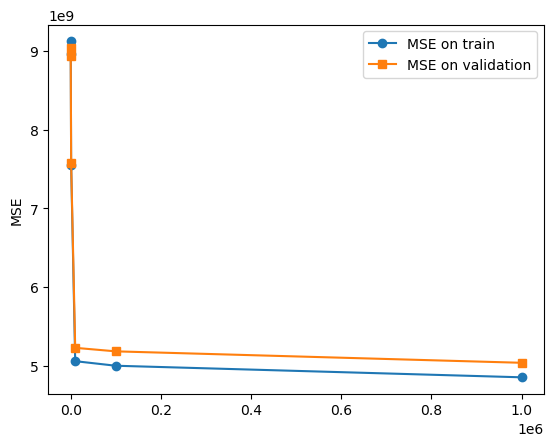

In [265]:
max_epochs = [10, 100, 1000, 10000, 100000, 1000000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=1, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr3 = LR3(lr=1e-4, max_epochs=epoch)
    lr3.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    MSE_val.append(mean_squared_error(lr3.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr3.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

In [266]:
print(f'MSE for linear regression is {min(MSE_val)}')

MSE for linear regression is 5036158797.563032


#### Degree 2

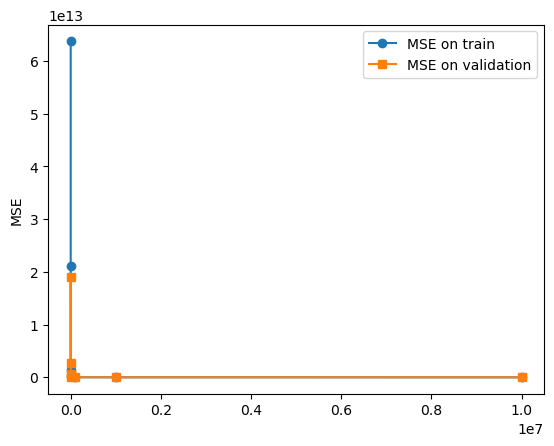

In [267]:
max_epochs = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr3 = LR3(lr=1e-10, max_epochs=epoch)
    lr3.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    MSE_val.append(mean_squared_error(lr3.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr3.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

In [268]:
print(f'MSE for linear regression is {min(MSE_val)}')

MSE for linear regression is 4975524829.17833


#### Degree 3

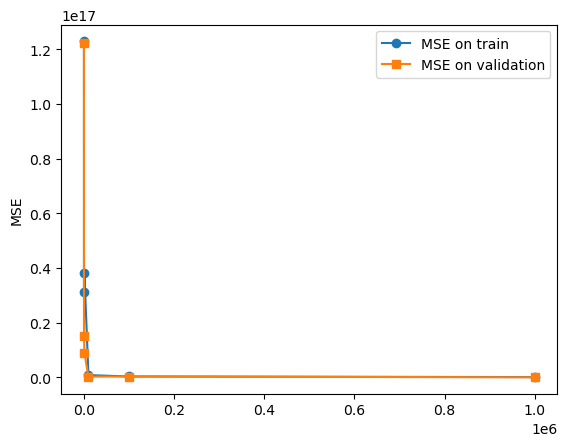

In [273]:
max_epochs = [10, 100, 1000, 10000, 100000, 1000000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr3 = LR3(lr=2e-15, max_epochs=epoch)
    lr3.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    MSE_val.append(mean_squared_error(lr3.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr3.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

In [274]:
print(f'MSE for linear regression is {min(MSE_val)}')

MSE for linear regression is 143659020834472.75


In [288]:
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
best_lr3_poly = LR3(lr=1e-10, max_epochs=100000)

### 4.4 Stohastic Gradient Descent Linear Regression

In [275]:
class LR4(LinearRegression):
    def fit(self, X, Y):
        if self.theta is None or self.theta.shape[0] != X.shape[1]:
            self.theta = np.zeros((X.shape[1], 1))
        
        for i in range(self.max_epochs):
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            
            for j in indices:
                x_j = X[j, :].reshape(-1, 1)
                y_j = Y[j, 0]
                
                error = y_j - (x_j.T @ self.theta)[0, 0]
                self.theta += self.lr * x_j * error    
#             if np.linalg.norm(self.theta-theta_prev) < self.eps:
#                 break

#### Degree 1

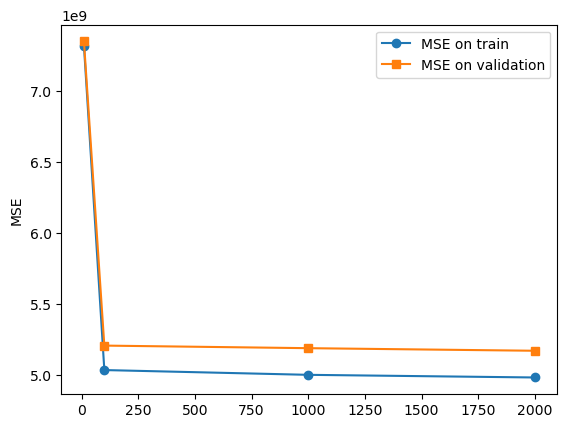

In [276]:
max_epochs = [10, 100, 1000, 2000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=1, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr4 = LR4(lr=1e-6, max_epochs=epoch)
    lr4.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    MSE_val.append(mean_squared_error(lr4.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr4.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

In [279]:
print(f'MSE for linear regression is {min(MSE_val)}')

MSE for linear regression is 5171154886.80174


#### Degree 2

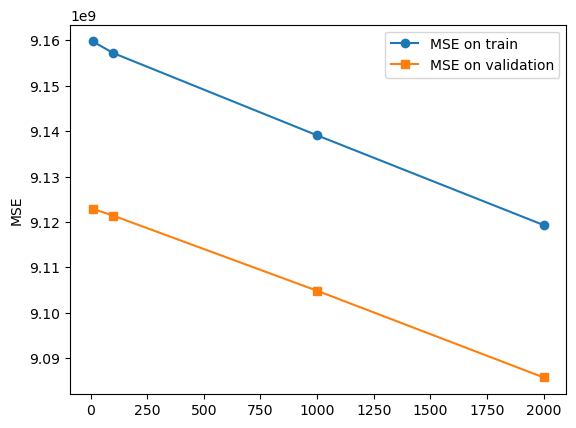

In [291]:
max_epochs = [10, 100, 1000, 2000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr2 = LR4(lr=1e-14, max_epochs=epoch)
    lr2.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    MSE_val.append(mean_squared_error(lr2.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr2.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

In [292]:
print(f'MSE for linear regression is {min(MSE_val)}')

MSE for linear regression is 9085757264.807524


#### Degree 3

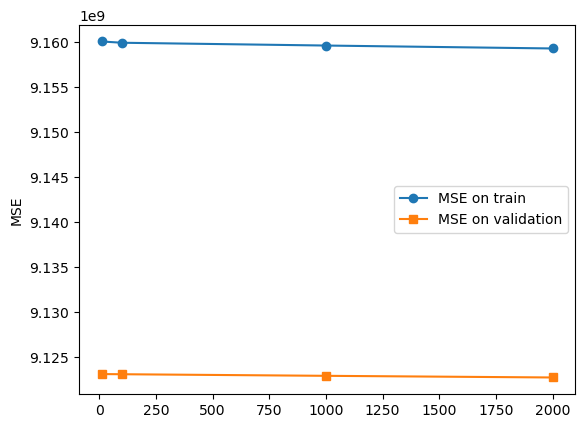

In [301]:
max_epochs = [10, 100, 1000, 2000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr2 = LR4(lr=1e-20, max_epochs=epoch)
    lr2.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    MSE_val.append(mean_squared_error(lr2.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr2.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

In [302]:
print(f'MSE for linear regression is {min(MSE_val)}')

MSE for linear regression is 9122700728.250977


### 4.5. Mini Batch Gradient Descent Linear Regression Model

In [304]:
class LR5(LinearRegression):
    def fit(self, X, Y, mb = 32):
        if self.theta is None or self.theta.shape[0] != X.shape[1]:
            self.theta = np.zeros((X.shape[1], 1))
        
        m = X.shape[0]
        for epoch in range(self.max_epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]
            
            for start in range(0, m, mb):
                end = start + mb
                X_batch = X_shuffled[start:end]
                Y_batch = Y_shuffled[start:end]
                
                gradient = - X_batch.T @ (Y_batch - X_batch @ self.theta) / X_batch.shape[0]
                self.theta -= self.lr * gradient

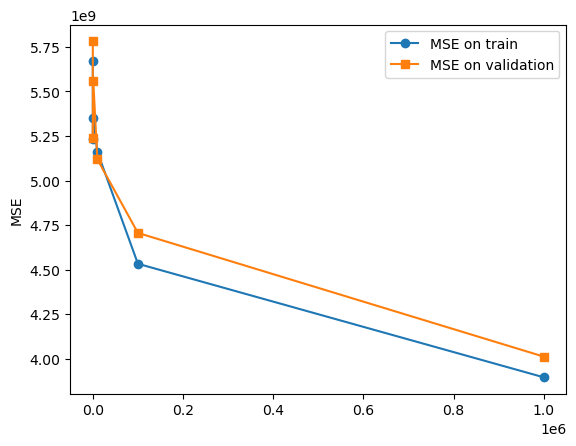

In [311]:
max_epochs = [10, 100, 1000, 10000, 100000, 1000000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=1, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr2 = LR5(lr=1e-4, max_epochs=epoch)
    lr2.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    MSE_val.append(mean_squared_error(lr2.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr2.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

In [312]:
print(f'MSE for linear regression is {min(MSE_val)}')

MSE for linear regression is 4011775181.2883654


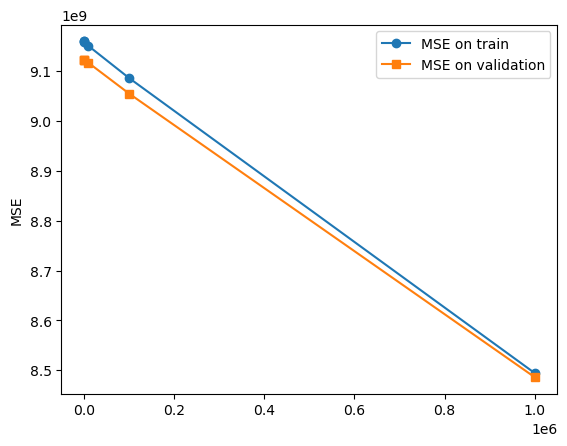

In [313]:
max_epochs = [10, 100, 1000, 10000, 100000, 1000000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr2 = LR5(lr=1e-17, max_epochs=epoch)
    lr2.fit(X_train_poly, Y_train_scaled.reshape(-1,1), mb = 200)
    MSE_val.append(mean_squared_error(lr2.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr2.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

In [314]:
print(f'MSE for linear regression is {min(MSE_val)}')

MSE for linear regression is 8485689231.072535


### 4.6. Batch Gradient Descent Linear Regression Model with L2 Regularization

In [323]:
class LR6(LinearRegression):
    def fit(self, X, Y, alpha = 0.01):
        if self.theta is None or self.theta.shape[0] != X.shape[1]:
            self.theta = np.zeros((X.shape[1], 1))
        
        for i in range(self.max_epochs):
            theta_prev = self.theta.copy()
            self.theta += self.lr *(( X.T @ (Y - X @ self.theta)) / X.shape[0] - alpha*self.theta)
#             if np.linalg.norm(self.theta-theta_prev) < self.eps:
#                 break

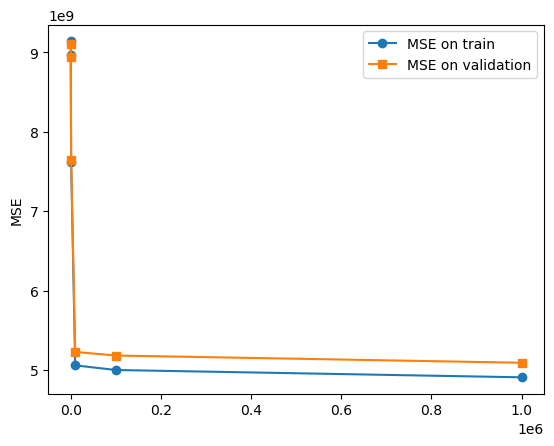

In [318]:
max_epochs = [10, 100, 1000, 10000, 100000, 1000000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=1, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr2 = LR6(lr=1e-4, max_epochs=epoch)
    lr2.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    MSE_val.append(mean_squared_error(lr2.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr2.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

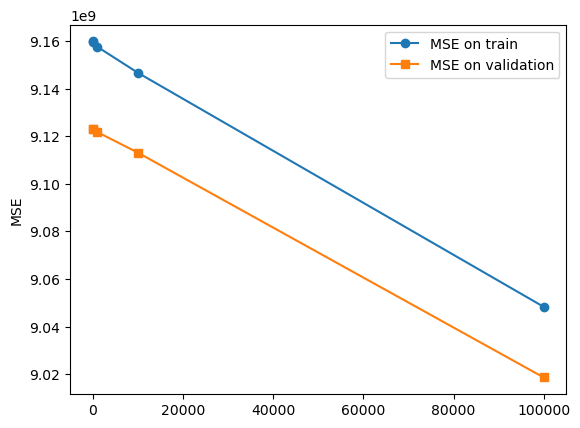

In [330]:
max_epochs = [10, 100, 1000, 10000, 100000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr2 = LR6(lr=1e-15, max_epochs=epoch)
    lr2.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    MSE_val.append(mean_squared_error(lr2.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr2.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

### 4.7. Momentum

In [333]:
class LR7(LinearRegression):
    def __init__(self, lr=0.01, max_epochs=1000, eps=1e-6, alpha=0.01, momentum=0.7):
        super().__init__(lr=lr, max_epochs=max_epochs, eps=eps)
        self.alpha = alpha
        self.momentum = momentum

    def fit(self, X, Y):
        if self.theta is None or self.theta.shape[0] != X.shape[1]:
            self.theta = np.zeros((X.shape[1], 1))

        velocity = np.zeros_like(self.theta)
        for i in range(self.max_epochs):
            gradient = (X.T @ (Y - X @ self.theta)) / X.shape[0] - self.alpha * self.theta

            velocity = self.momentum * velocity + self.lr * gradient
            theta_prev = self.theta.copy()
            self.theta += velocity



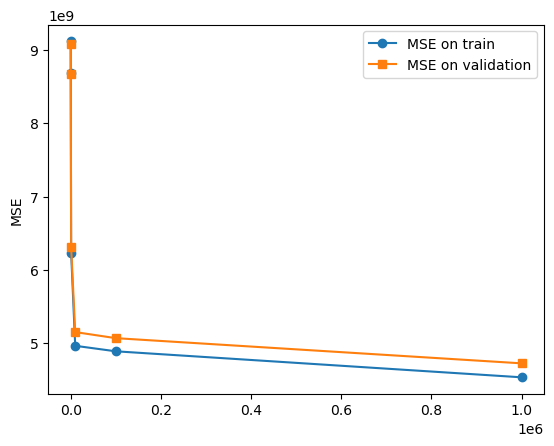

In [334]:
max_epochs = [10, 100, 1000, 10000, 100000, 1000000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr2 = LR7(lr=1e-8, max_epochs=epoch)
    lr2.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    MSE_val.append(mean_squared_error(lr2.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr2.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

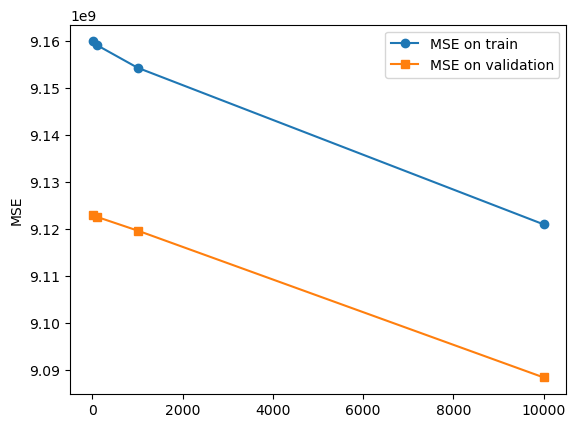

In [327]:
max_epochs = [10, 100, 1000, 10000]
MSE_train = []
MSE_val = []
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
for epoch in max_epochs:
    lr2 = LR7(lr=1e-15, max_epochs=epoch)
    lr2.fit(X_train_poly, Y_train_scaled.reshape(-1,1))
    MSE_val.append(mean_squared_error(lr2.predict(X_val_poly)*Y_std+Y_mean, Y_val))
    MSE_train.append(mean_squared_error(lr2.predict(X_train_poly)*Y_std+Y_mean, Y_train))   

plt.figure()
plt.plot(max_epochs, MSE_train, marker='o')
plt.plot(max_epochs, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

### 4.8. Locally Weighted Linear Regression

Due to long computing time we will only look at 5000 training and 1000 validation samples.

In [51]:
class LocallyWeightedLinearRegression():
    """Locally Weighted Regression (LWR).    """

    def __init__(self, tau):
        self.tau = tau
        self.x = None
        self.y = None

    def fit(self, x, y):
        """Fit LWR by saving the training set.

        """
        self.x = x
        self.y = y.reshape(-1,1)

    def predict(self, x):
        """Make predictions given inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        m, n = x.shape
        pred = np.zeros(m)

        for i in range(m):
            query = x[i]

            w = np.exp(-np.sum((self.x - query) ** 2, axis=1) / (2 * self.tau ** 2))
            W = np.diag(w)

            XTWX = self.x.T @ W @ self.x
            XTWy = self.x.T @ W @ self.y
            theta = np.linalg.pinv(XTWX + 1e-8 * np.eye(XTWX.shape[0])) @ XTWy
            pred[i] = (query @ theta).item()

        return pred

0.01
0.12
0.23
0.34
0.45
0.56
0.67
0.78
0.89
1.0


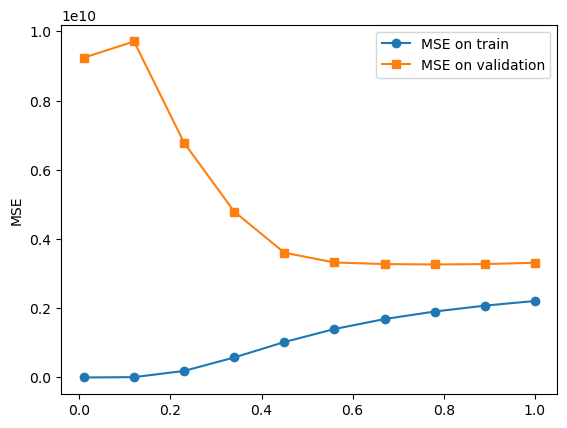

In [60]:
poly = PolynomialFeatures(degree=1, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
MSE_val = []
MSE_train = []

taus = np.linspace(0.01, 1, 10)

X_train_polys = X_train_poly[:5000, :]
Y_trains = Y_train[:5000]
Y_train_scaleds = Y_train_scaled[:5000]
X_val_polys = X_val_poly[:1000, :]
Y_vals = Y_val[:1000]

for tau in taus:
    print(tau)
    lwlr = LocallyWeightedLinearRegression(tau)
    lwlr.fit(X_train_polys, Y_train_scaleds.reshape(-1,1))
    MSE_val.append(mean_squared_error(lwlr.predict(X_val_polys)*Y_std+Y_mean, Y_vals))
    MSE_train.append(mean_squared_error(lwlr.predict(X_train_polys)*Y_std+Y_mean, Y_trains))   

plt.figure()
plt.plot(taus, MSE_train, marker='o')
plt.plot(taus, MSE_val, marker='s')
plt.legend(['MSE on train', 'MSE on validation'])
plt.ylabel('MSE')
plt.show()

In [61]:
print(f'Best fitting tau is {taus[np.argmin(MSE_val)]} of Polynomial Regression and MSE is {min(MSE_val):.2f}')

Best fitting tau is 0.78 of Polynomial Regression and MSE is 3265629081.11


### Evaluation of test set

The best performing model is the model with Newton's method, let's see how it performs on a test set

In [96]:
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)
Y_pred_test = best_lr2_poly.predict(X_test_poly)* Y_std + Y_mean

print(f'MSE is {mean_squared_error(Y_pred_test, Y_test):.2f}')

MSE is 4251495882.07
